In [56]:
import os
import pandas as pd
import numpy as np

# Define the base directory
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, 'Hourly Energy Consumption')

# Define utilities with file names
utilities = {
    'AEP': 'AEP_hourly.csv',
    'COMED': 'COMED_hourly.csv',
    'DAYTON': 'DAYTON_hourly.csv',
    'DEOK': 'DEOK_hourly.csv',
    'DOM': 'DOM_hourly.csv',
    'DUQ': 'DUQ_hourly.csv',
    'EKPC': 'EKPC_hourly.csv',
    'FE': 'FE_hourly.csv',
    'NI': 'Ni_hourly.csv',
    'PJMW': 'PJMW_hourly.csv'
}

# Function to remove outliers
def remove_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return series[(series > mean - threshold * std) & (series < mean + threshold * std)]

# Function to handle duplicate timestamps
def handle_duplicates(df, mw_col):
    # Group by index and aggregate using mean
    df = df.groupby(df.index).mean()
    return df

# Preprocess function that loads data, handles outliers, duplicates, and adds time-based features
def preprocess_data(file_path, mw_col):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Handle duplicates
    df = handle_duplicates(df, mw_col=mw_col)

    # Remove outliers
    df[mw_col] = remove_outliers(df[mw_col])

    # Drop any remaining missing values
    df.dropna(inplace=True)

    # Add time-based features: hour, day_of_week, and month
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year

    return df

# Go over all utilities and preprocess the data
processed_data = {}
for utility, filename in utilities.items():
    file_path = os.path.join(base_dir, filename)
    df = preprocess_data(file_path, mw_col=f'{utility}_MW')
    processed_data[utility] = df

# print data preprocessing to confirm it was done for all utilities
for utility, df in processed_data.items():
    print(f"Preprocessed data for {utility}:")
    print(df.head())

Root Mean Squared Error (RMSE) for AEP (Linear Regression Model): 2097.9760702988674
RMSE: 2097.98
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 11.86%


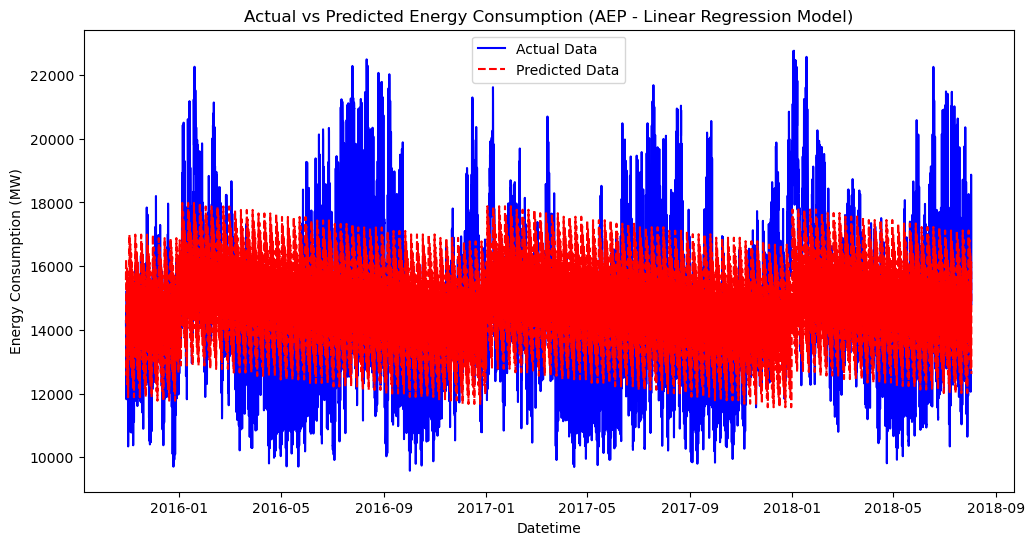

Root Mean Squared Error (RMSE) for COMED (Linear Regression Model): 1716.5196508951653
RMSE: 1716.52
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 11.89%


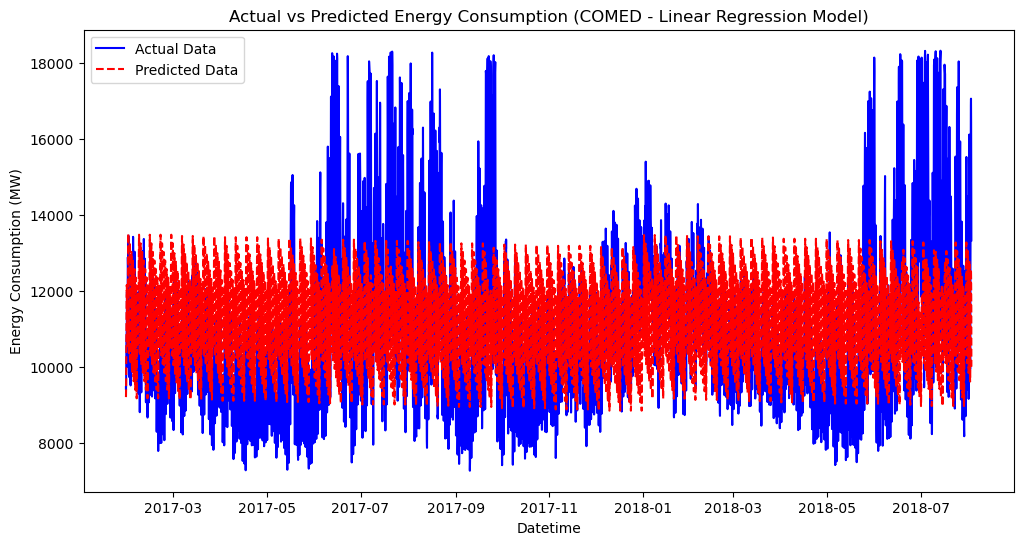

Root Mean Squared Error (RMSE) for DAYTON (Linear Regression Model): 308.19280815525036
RMSE: 308.19
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 11.69%


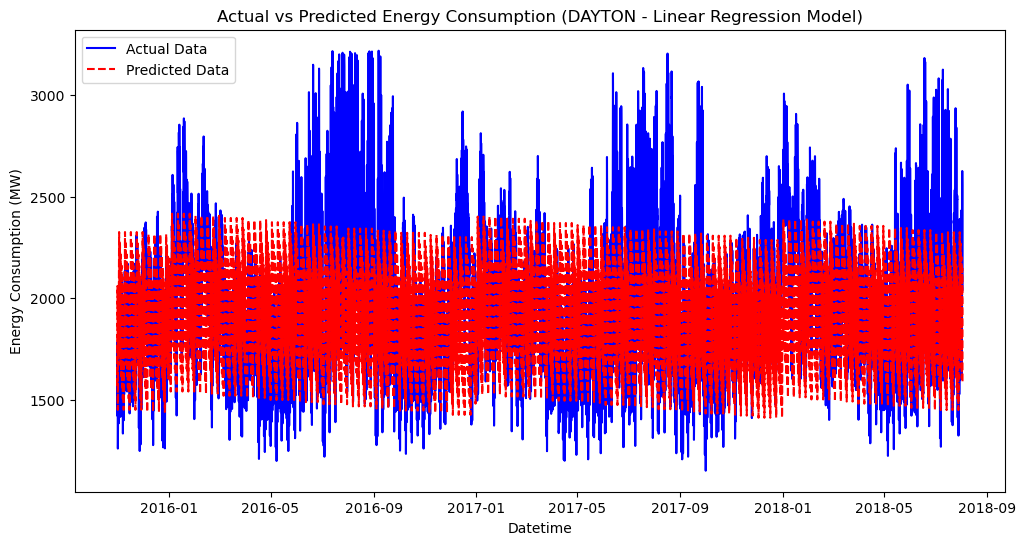

Root Mean Squared Error (RMSE) for DEOK (Linear Regression Model): 499.83410763728705
RMSE: 499.83
Normalized RMSE (Range): 0.14
Mean Absolute Percentage Error (MAPE): 12.78%


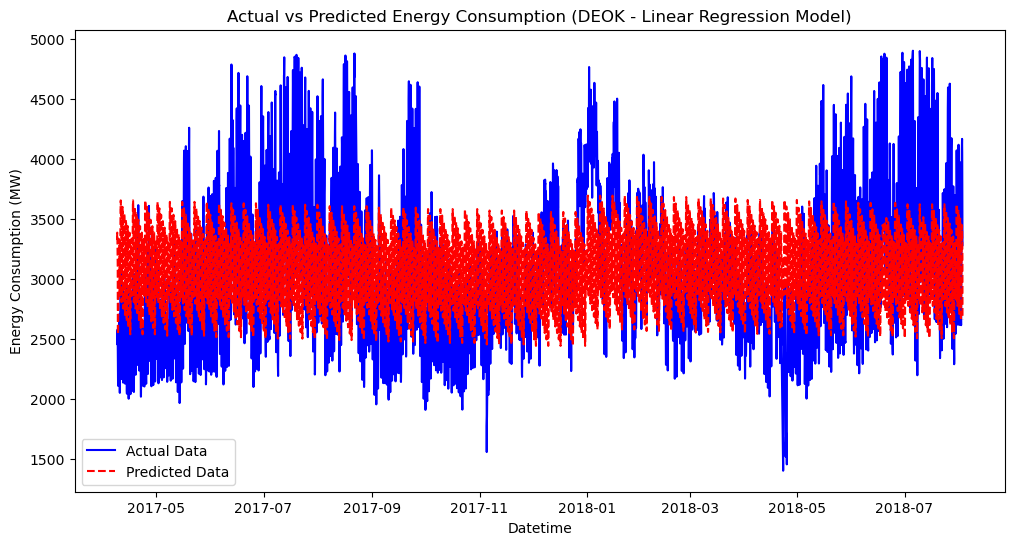

Root Mean Squared Error (RMSE) for DOM (Linear Regression Model): 2109.6998914705014
RMSE: 2109.70
Normalized RMSE (Range): 0.18
Mean Absolute Percentage Error (MAPE): 15.27%


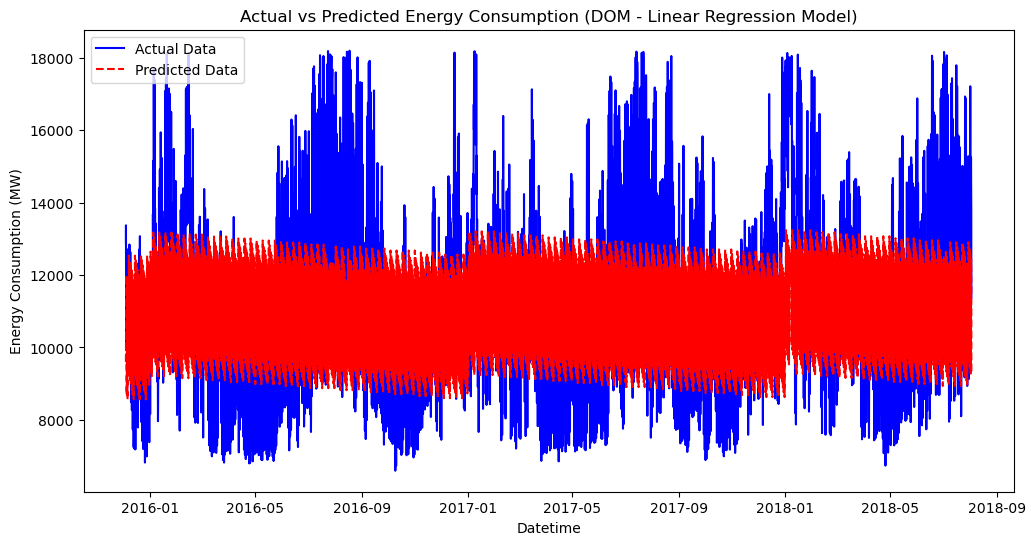

Root Mean Squared Error (RMSE) for DUQ (Linear Regression Model): 255.33435754877945
RMSE: 255.33
Normalized RMSE (Range): 0.17
Mean Absolute Percentage Error (MAPE): 14.16%


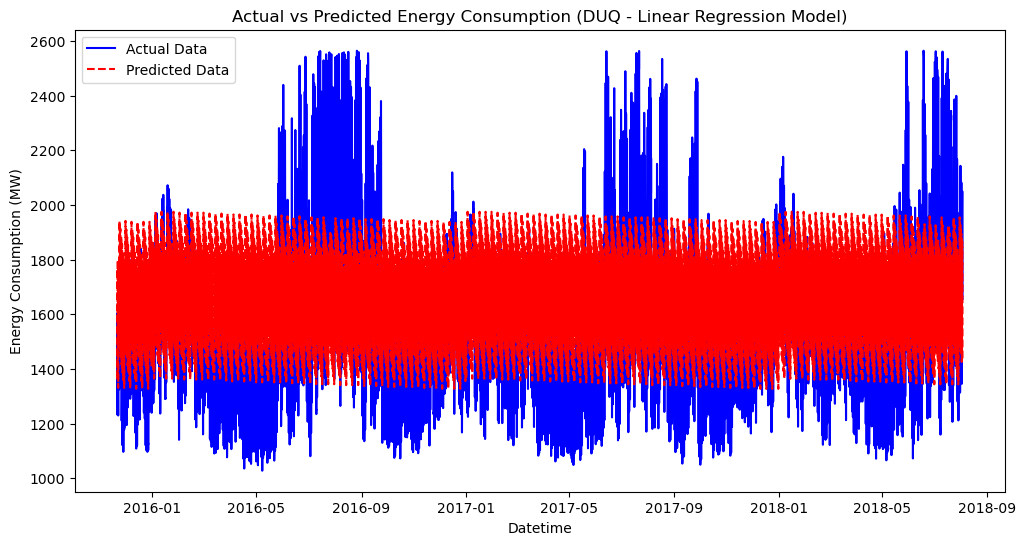

Root Mean Squared Error (RMSE) for EKPC (Linear Regression Model): 334.73945822631566
RMSE: 334.74
Normalized RMSE (Range): 0.19
Mean Absolute Percentage Error (MAPE): 15.94%


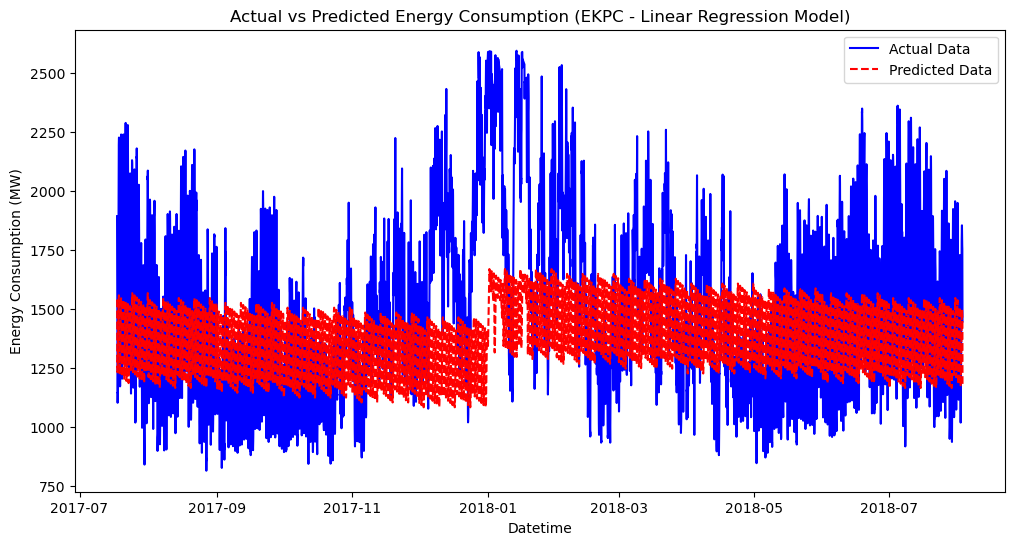

Root Mean Squared Error (RMSE) for FE (Linear Regression Model): 1013.182699513354
RMSE: 1013.18
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 10.55%


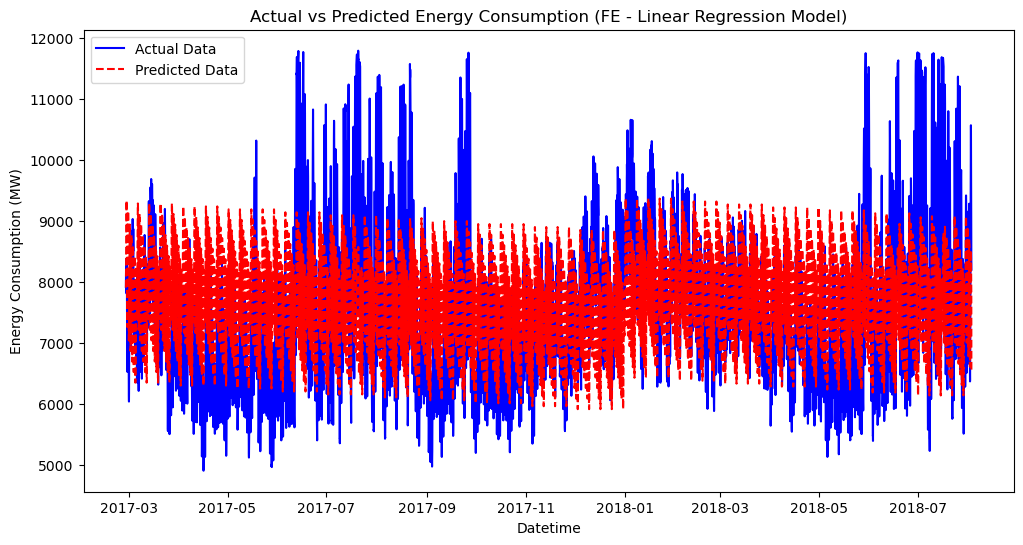

Root Mean Squared Error (RMSE) for NI (Linear Regression Model): 1793.8640070521592
RMSE: 1793.86
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 12.81%


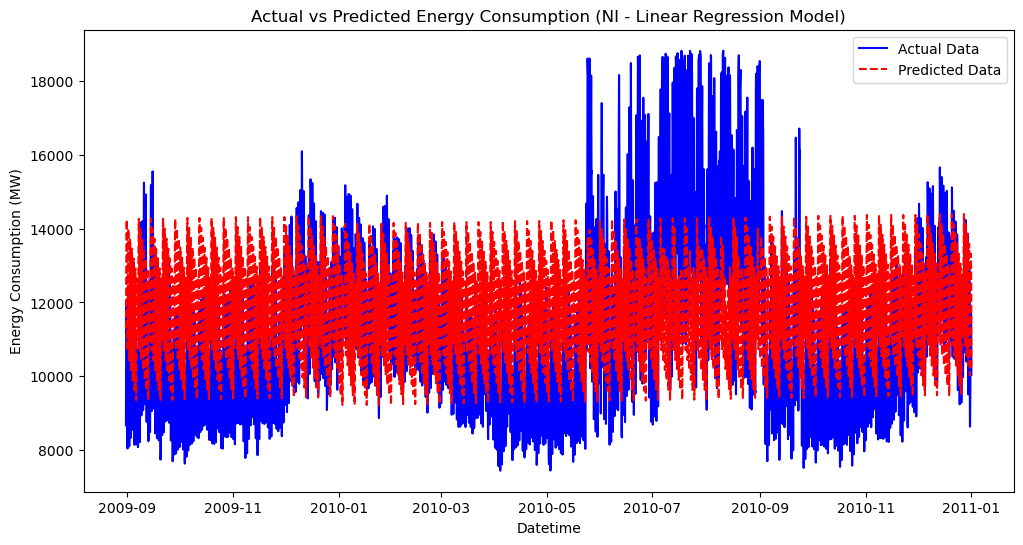

Root Mean Squared Error (RMSE) for PJMW (Linear Regression Model): 823.4991127719518
RMSE: 823.50
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 11.60%


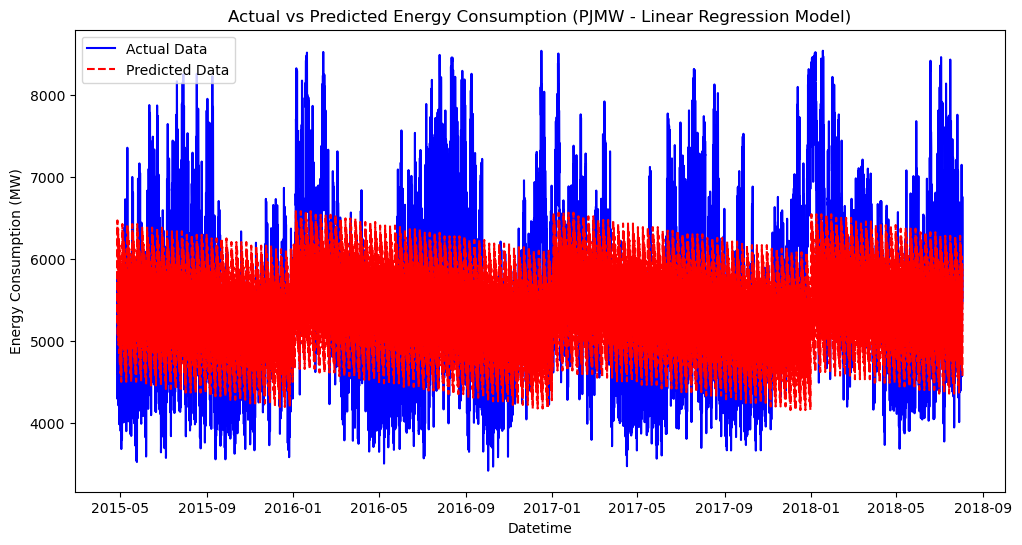

In [65]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Basic linear regression model
for utility, df in processed_data.items():
    target = f'{utility}_MW'

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Setting features
    features = ['hour', 'day_of_week', 'month', 'year','hour_sin','hour_cos'] 
    X = df[features]
    y = df[target]

    df = df.dropna()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Training the Linear Regression model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Making predictions
    y_pred = lr.predict(X_test)

    # Evaluate the model using RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE) for {utility} (Linear Regression Model): {rmse}")

    nrmse_range = rmse / (y_test.max() - y_test.min())
    nrmse_mean = rmse / y_test.mean()
    nrmse_std = rmse / y_test.std()


    print(f"RMSE: {rmse:.2f}")
    print(f"Normalized RMSE (Range): {nrmse_range:.2f}")

    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

    # Visualize Results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Energy Consumption ({utility} - Linear Regression Model)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # Coefficients of the Linear Regression model
    #coefficients = lr.coef_
    #feature_importance = dict(zip(features, coefficients))
    #plt.bar(feature_importance.keys(), feature_importance.values(), color='green')
    #plt.title(f'Feature Coefficients ({utility} - Linear Regression Model)')
    #plt.xticks(rotation=45)
    #plt.show()

RMSE: 2069.70
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 12.14%


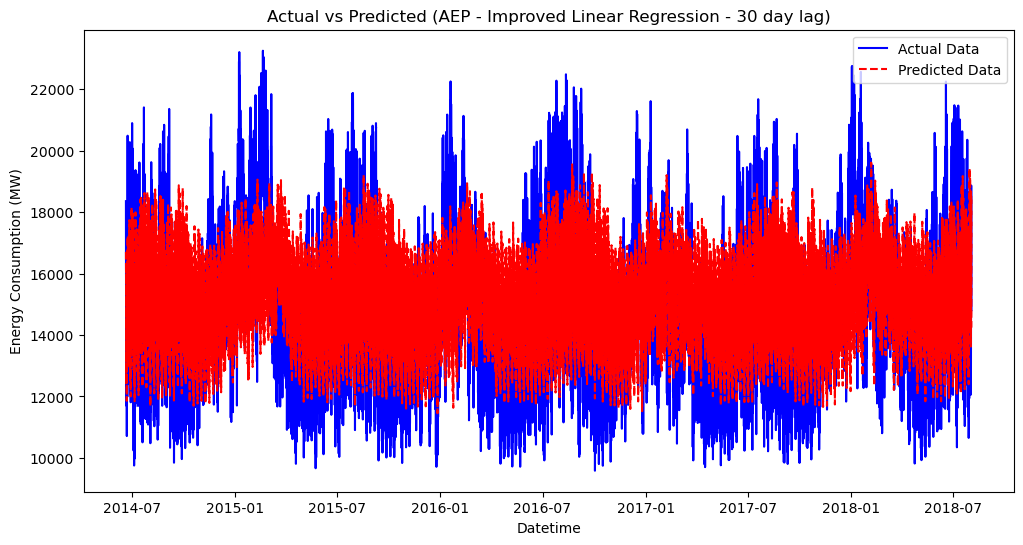

RMSE: 1772.42
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 11.95%


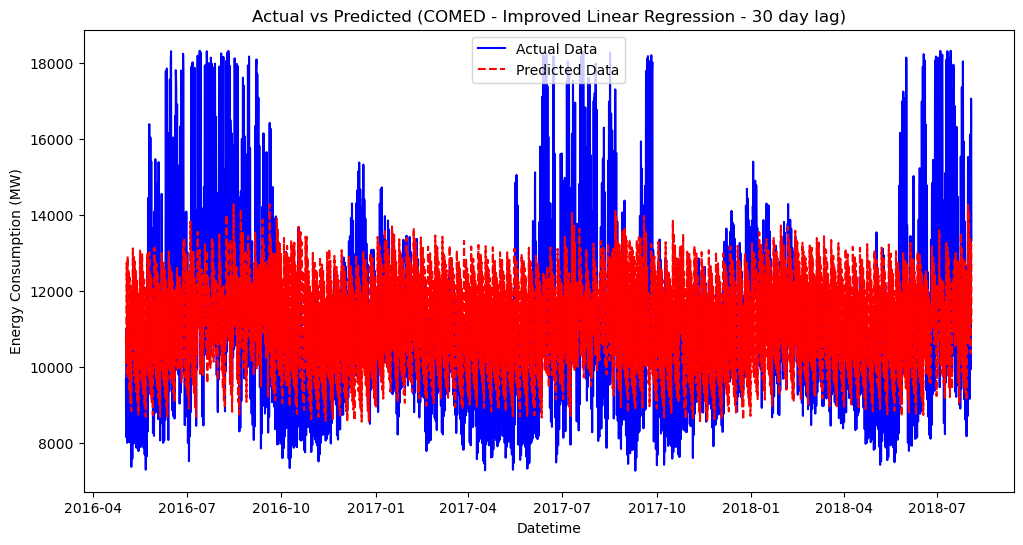

RMSE: 289.87
Normalized RMSE (Range): 0.14
Mean Absolute Percentage Error (MAPE): 12.00%


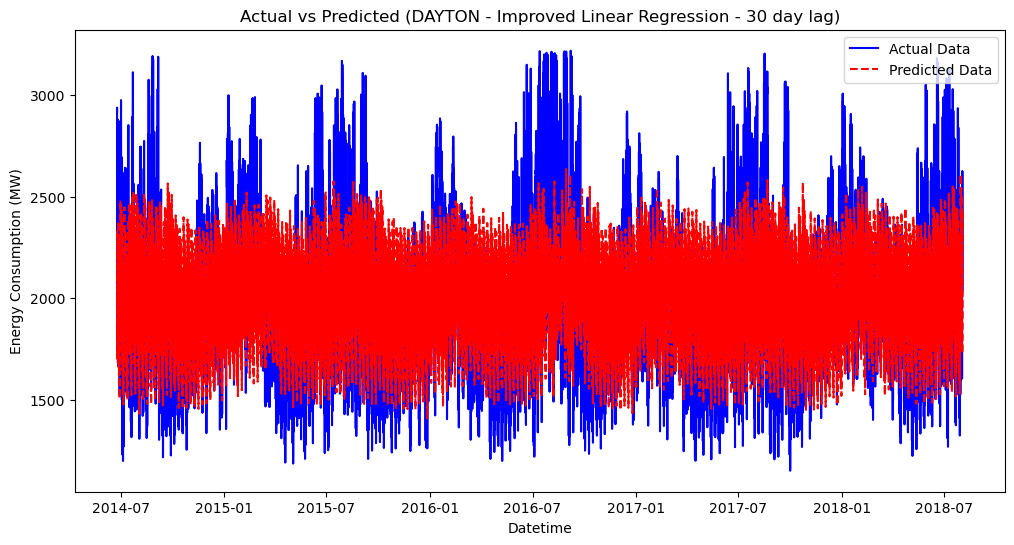

RMSE: 474.92
Normalized RMSE (Range): 0.14
Mean Absolute Percentage Error (MAPE): 12.31%


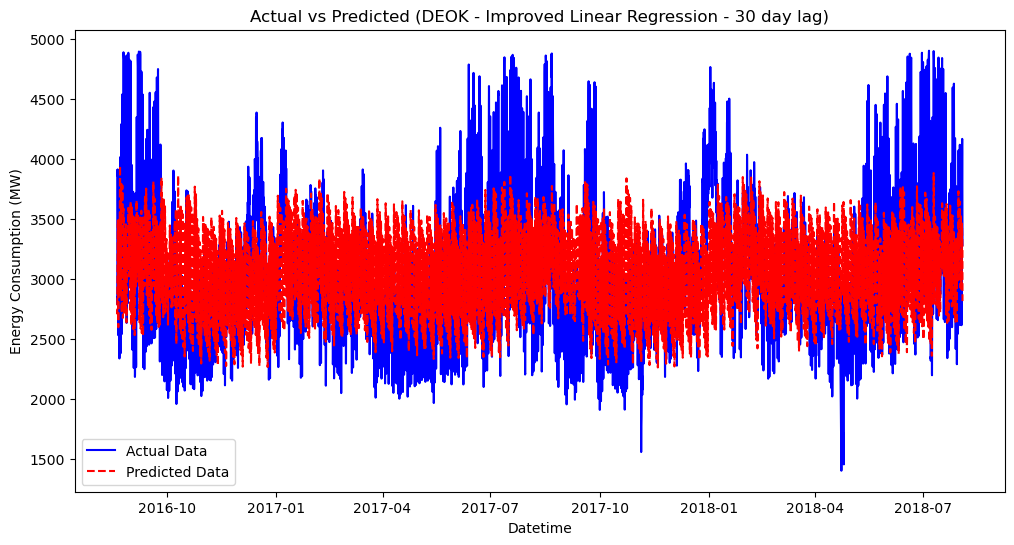

RMSE: 2058.87
Normalized RMSE (Range): 0.18
Mean Absolute Percentage Error (MAPE): 14.44%


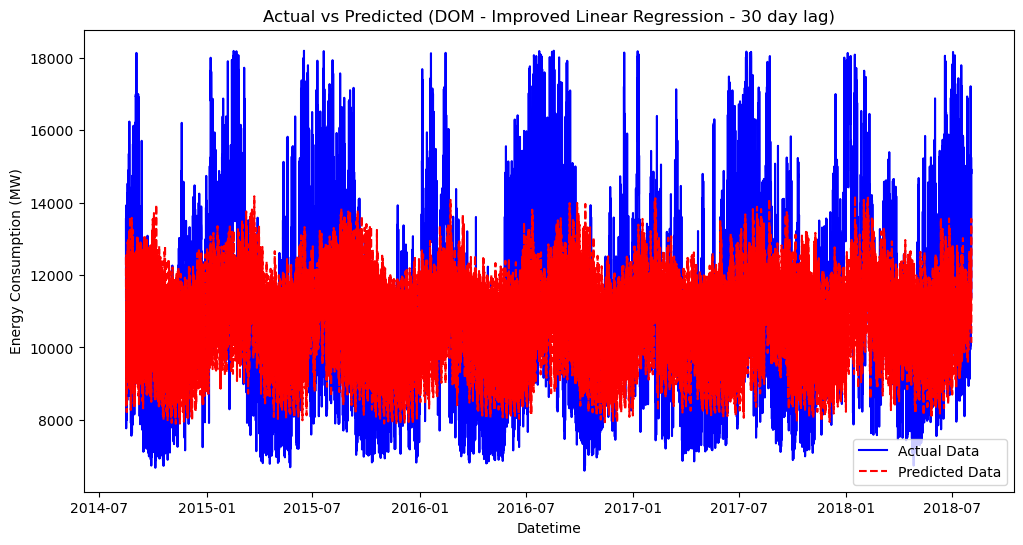

RMSE: 242.50
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 13.05%


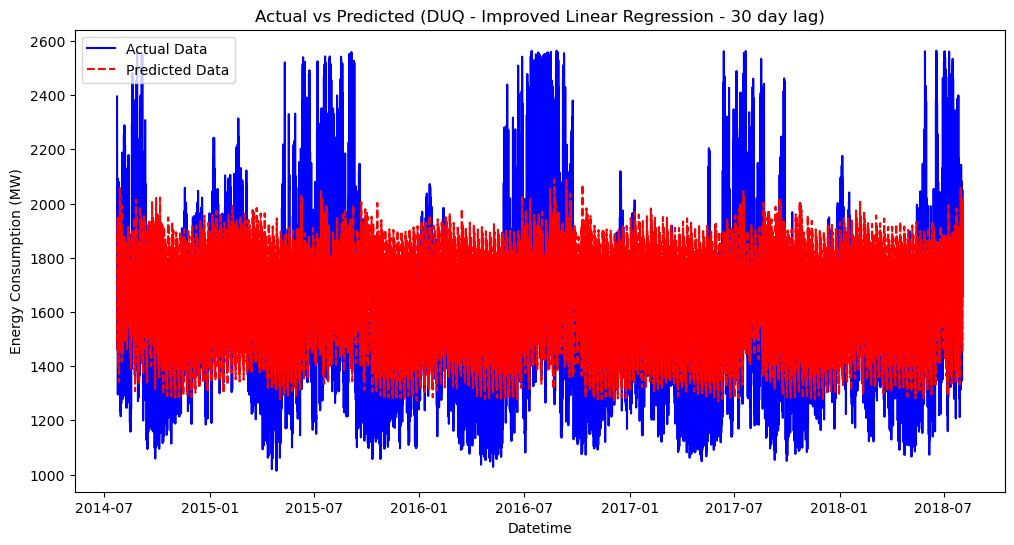

RMSE: 293.80
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 16.27%


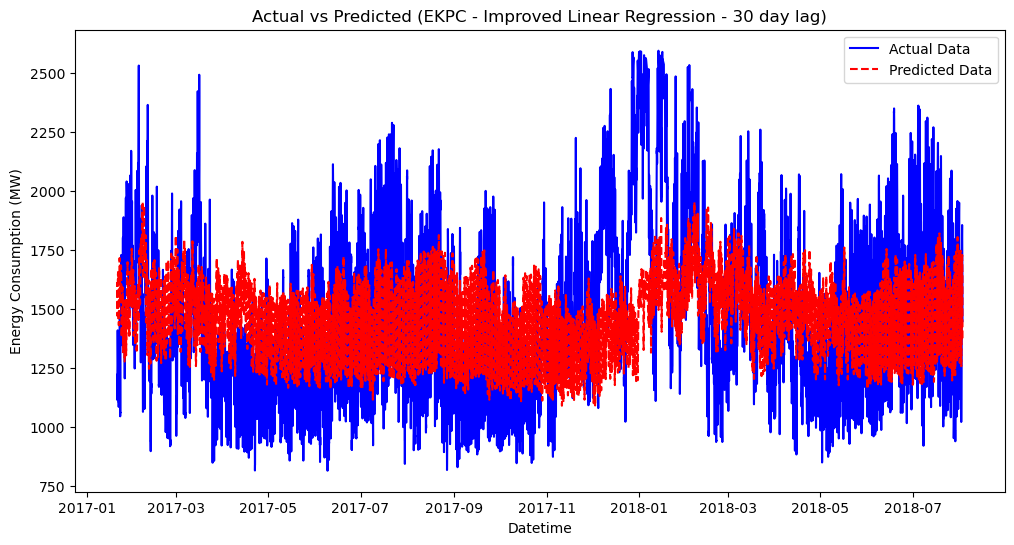

RMSE: 1042.19
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 10.49%


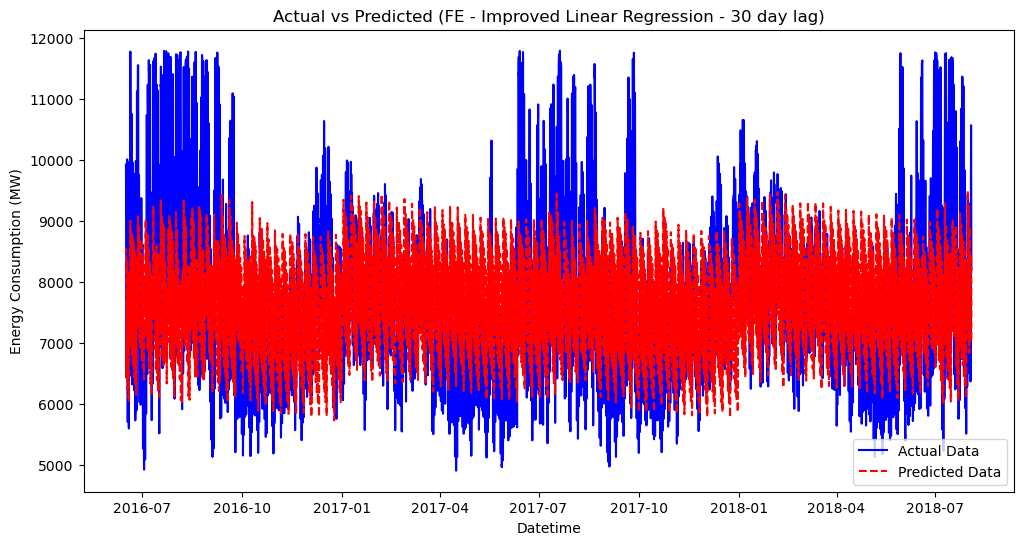

RMSE: 1688.68
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 11.86%


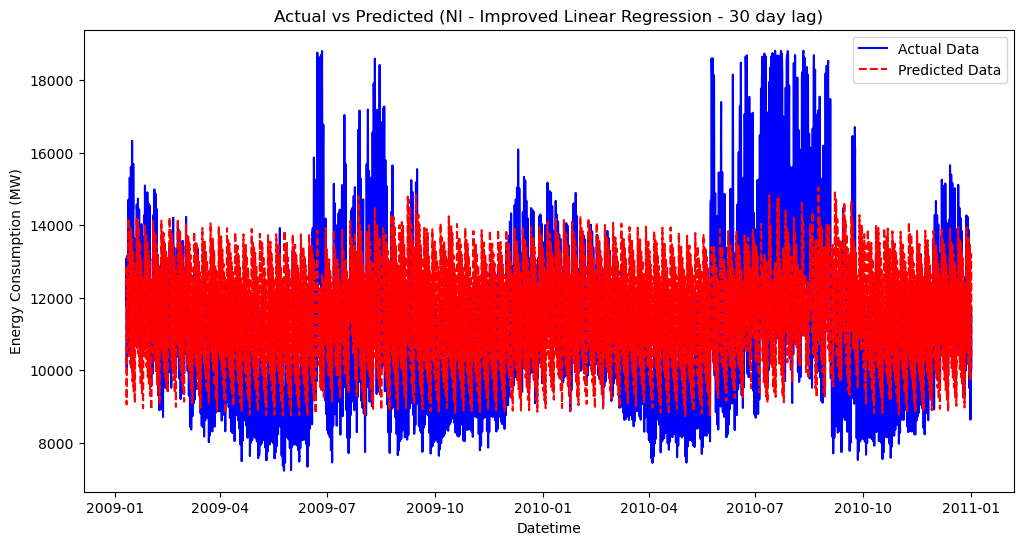

RMSE: 807.55
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 11.53%


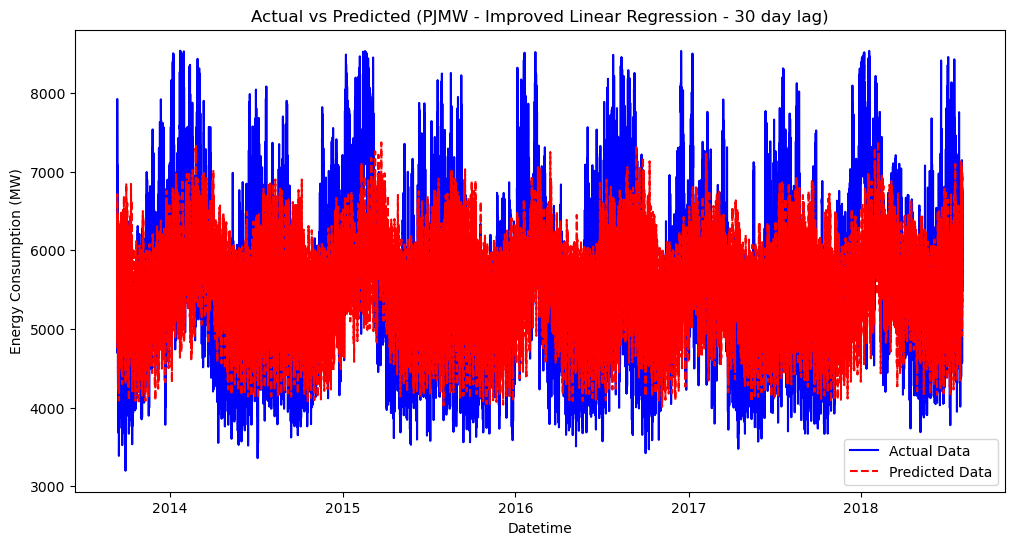

In [66]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Create cyclical and lag features
for utility, df in processed_data.items():
    target = f'{utility}_MW'
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['lag_month'] = df[target].shift(720)


    # Drop rows with NaN due to lag/rolling features
    df = df.dropna()

    # Setting features
    features = ['hour', 'day_of_week', 'month', 'lag_month','hour_sin','hour_cos']
    X = df[features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, shuffle=False)

    # Model training
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Prediction evalutaion and normalization
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    nrmse_range = rmse / (y_test.max() - y_test.min())

    print(f"RMSE: {rmse:.2f}")
    print(f"Normalized RMSE (Range): {nrmse_range:.2f}")

    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted ({utility} - Improved Linear Regression - 30 day lag)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()
    


RMSE: 1845.53
Normalized RMSE (Range): 0.13
Mean Absolute Percentage Error (MAPE): 10.29%


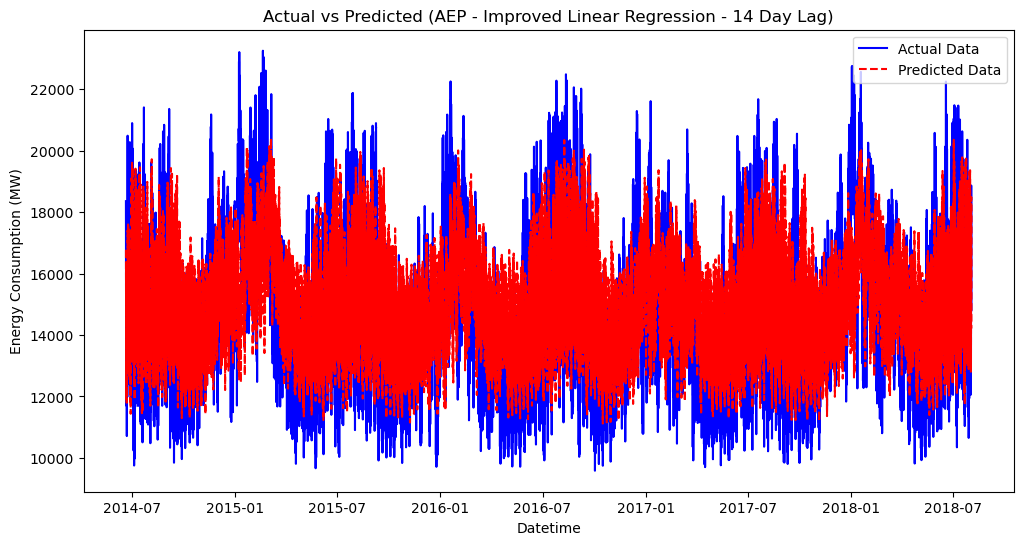

RMSE: 1703.08
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 11.07%


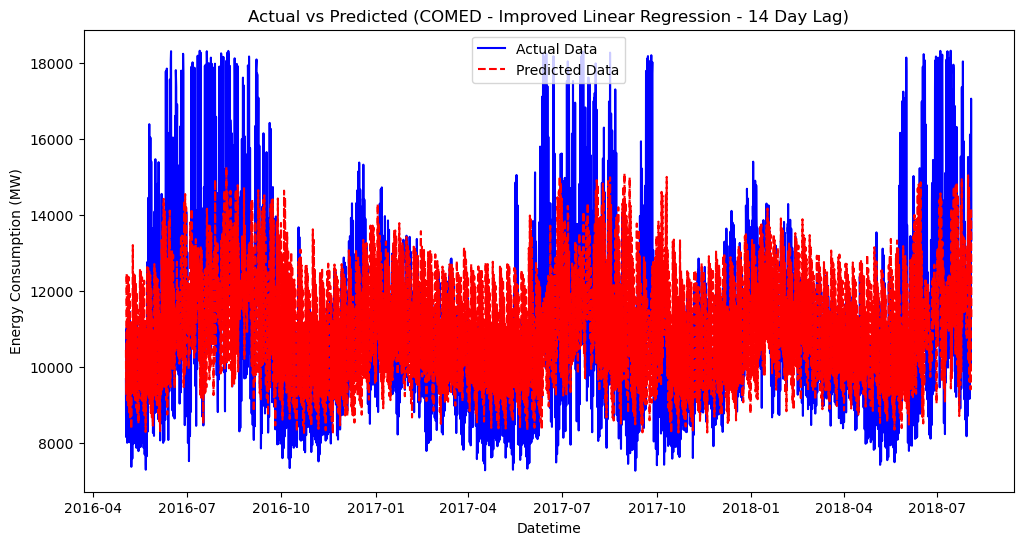

RMSE: 271.03
Normalized RMSE (Range): 0.13
Mean Absolute Percentage Error (MAPE): 10.87%


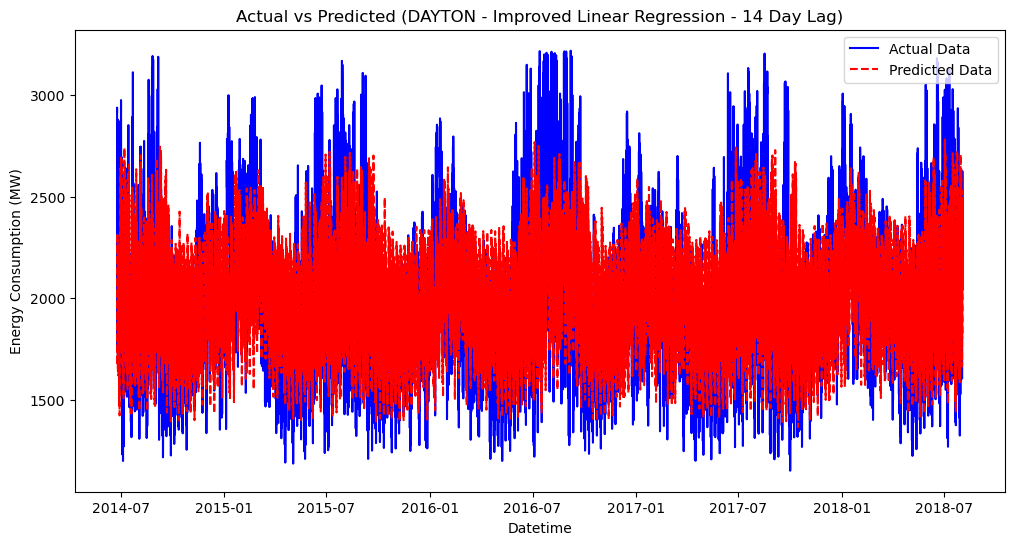

RMSE: 459.83
Normalized RMSE (Range): 0.13
Mean Absolute Percentage Error (MAPE): 11.63%


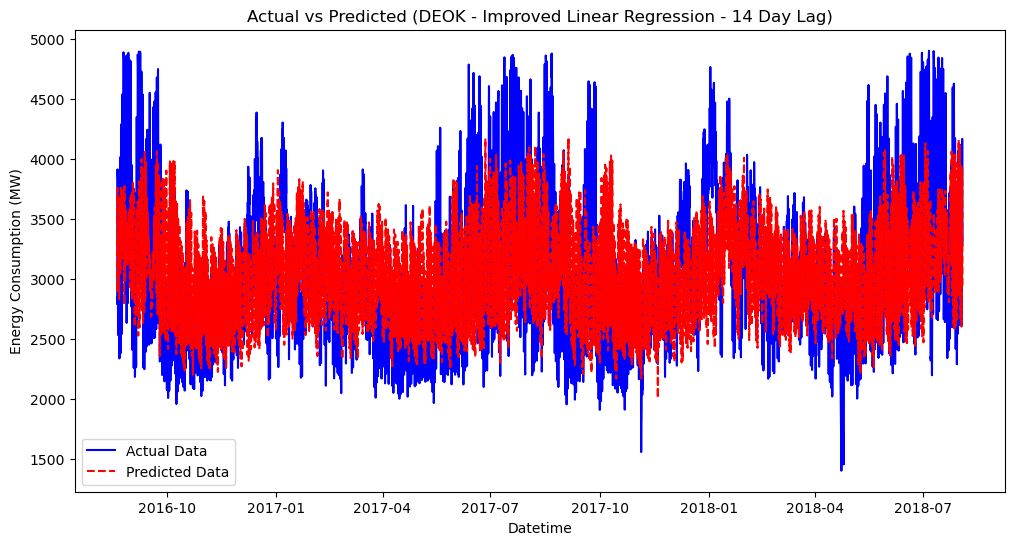

RMSE: 1908.48
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 12.99%


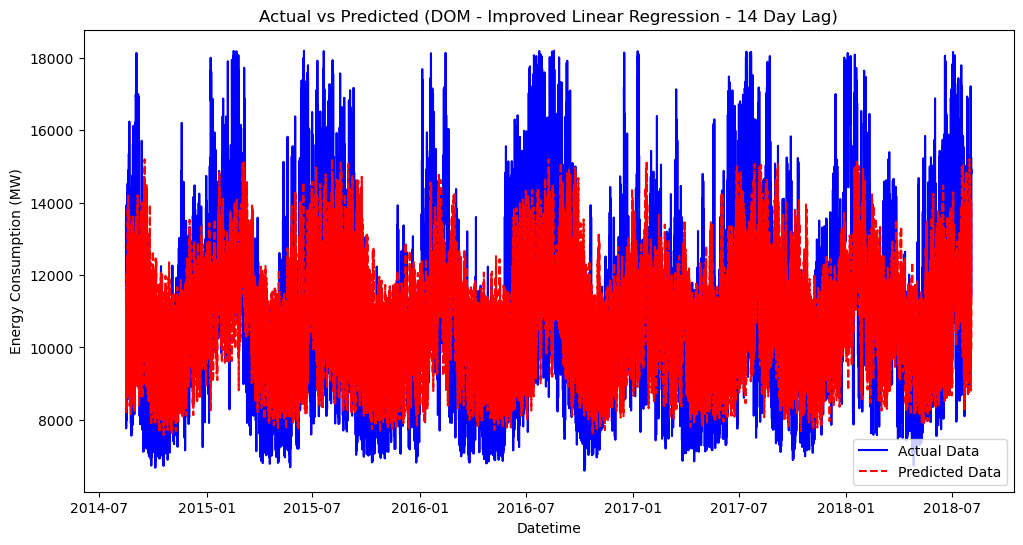

RMSE: 223.14
Normalized RMSE (Range): 0.14
Mean Absolute Percentage Error (MAPE): 11.58%


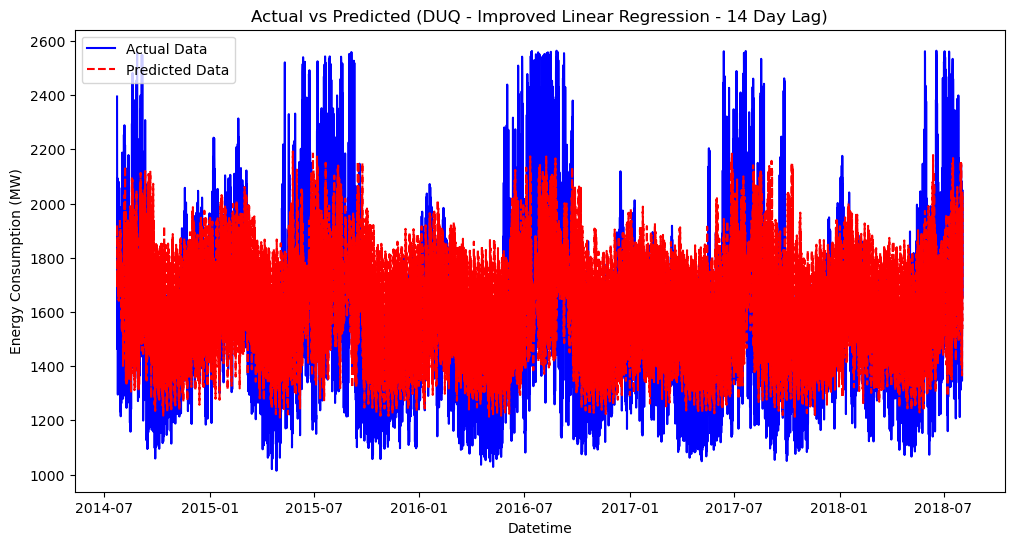

RMSE: 278.62
Normalized RMSE (Range): 0.16
Mean Absolute Percentage Error (MAPE): 15.00%


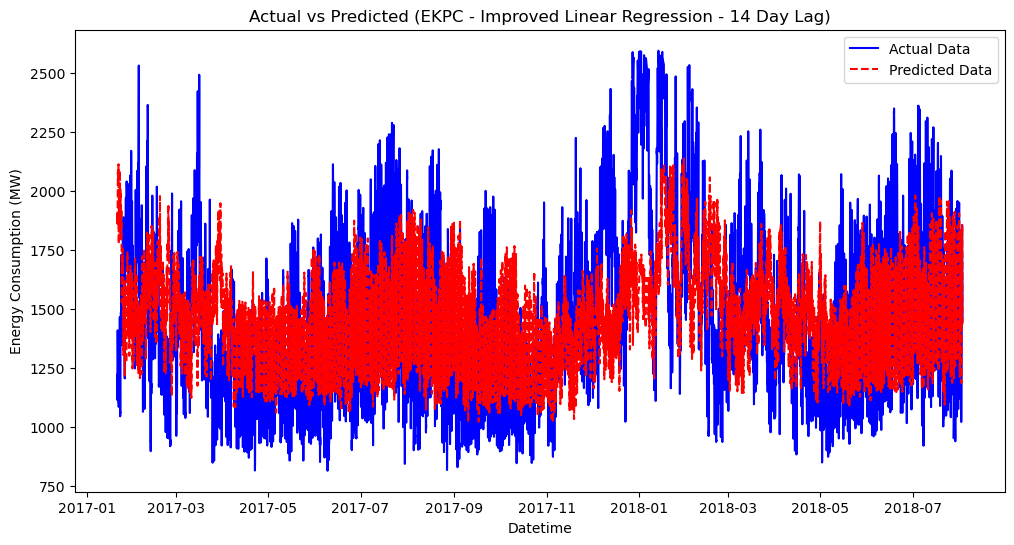

RMSE: 1014.04
Normalized RMSE (Range): 0.15
Mean Absolute Percentage Error (MAPE): 9.92%


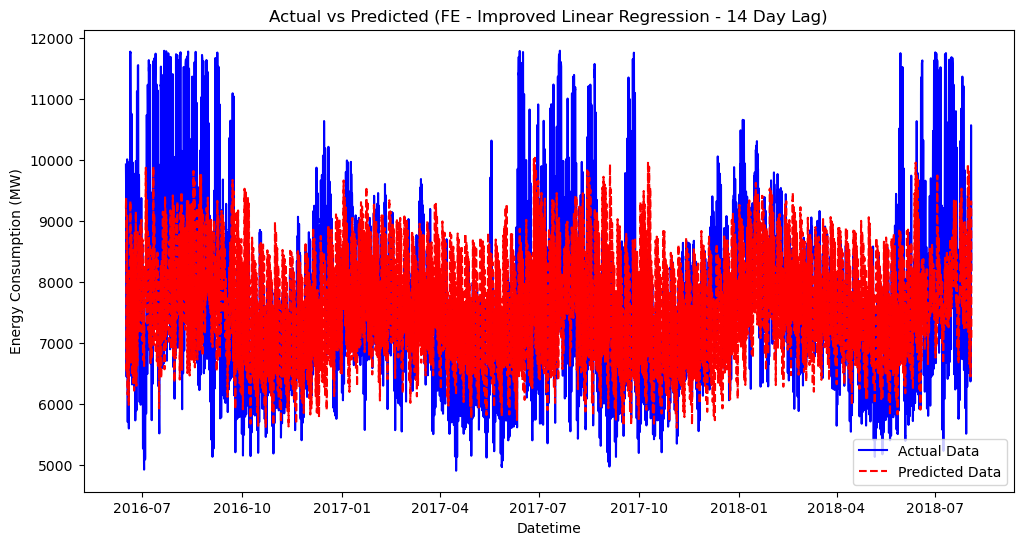

RMSE: 1544.90
Normalized RMSE (Range): 0.13
Mean Absolute Percentage Error (MAPE): 10.26%


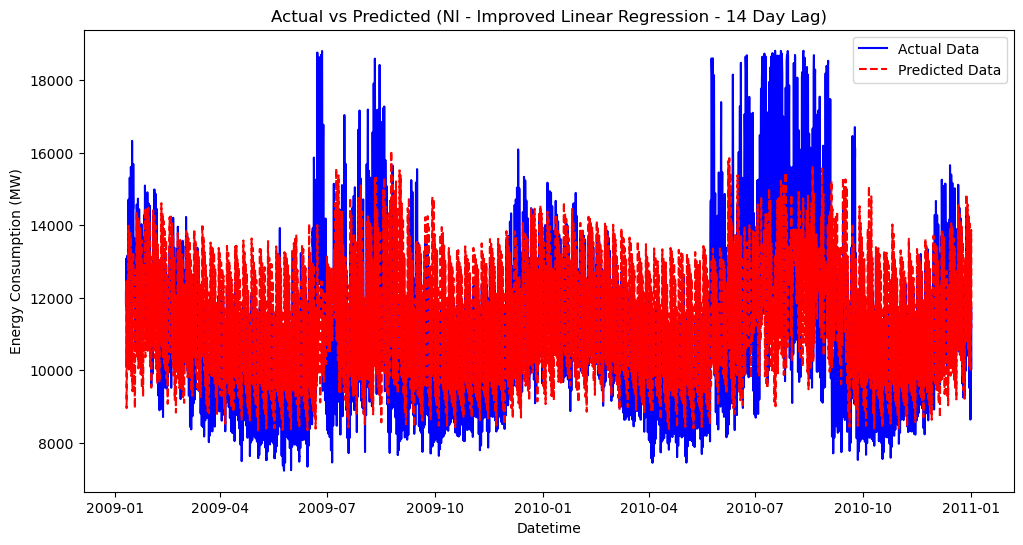

RMSE: 725.98
Normalized RMSE (Range): 0.14
Mean Absolute Percentage Error (MAPE): 9.94%


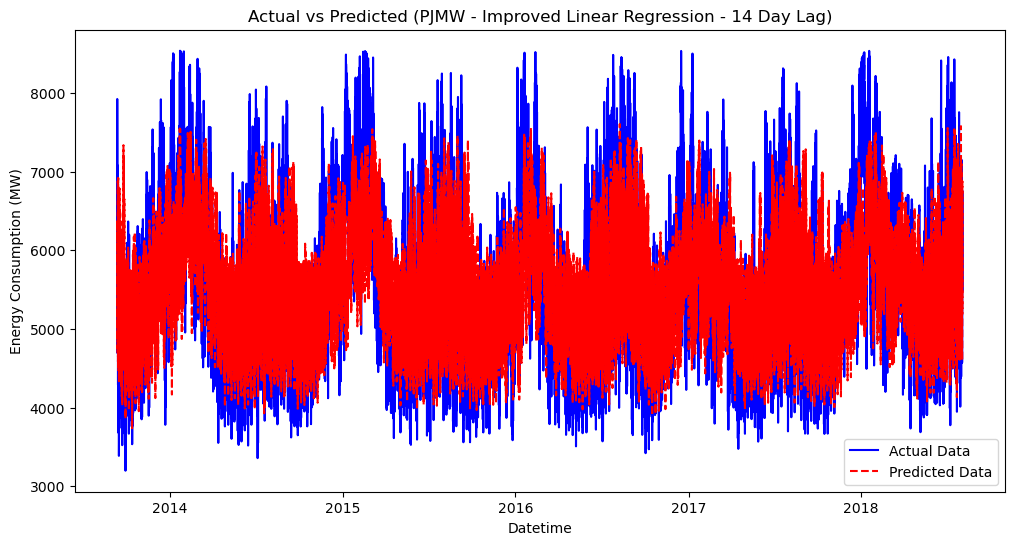

In [67]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Create cyclical and lag features
for utility, df in processed_data.items():

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    target = f'{utility}_MW'
    df['lag_2week'] = df[target].shift(336)


    # Drop rows with NaN due to lag/rolling features
    df = df.dropna()

    # Setting features
    features = ['hour', 'day_of_week', 'month', 'lag_2week','hour_cos','hour_sin']
    X = df[features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, shuffle=False)

    # Model training
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Prediction evalutaion and normalization
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    nrmse_range = rmse / (y_test.max() - y_test.min())

    print(f"RMSE: {rmse:.2f}")
    print(f"Normalized RMSE (Range): {nrmse_range:.2f}")
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted ({utility} - Improved Linear Regression - 14 Day Lag)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

RMSE: 1034.73
Normalized RMSE (Range): 0.08
Mean Absolute Percentage Error (MAPE): 5.46%


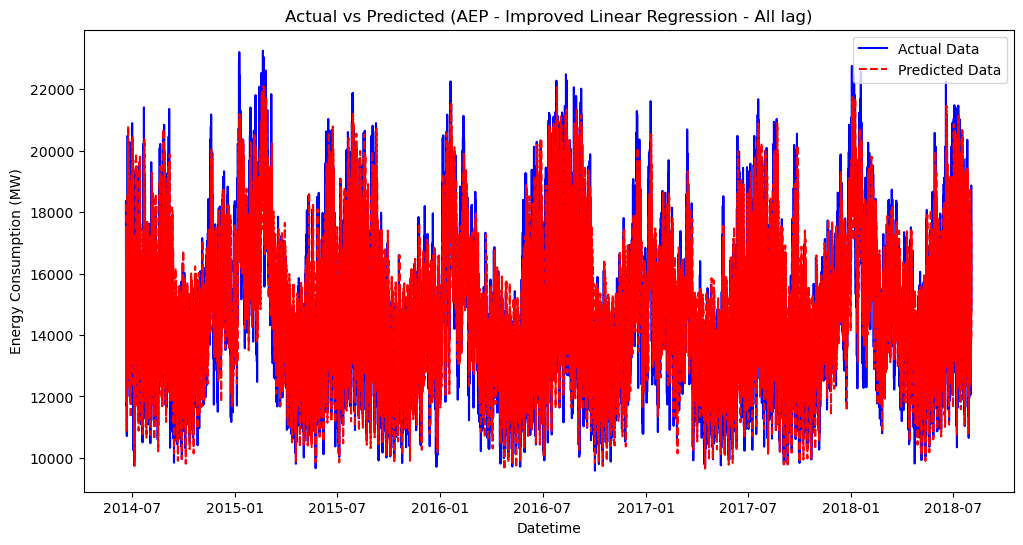

RMSE: 1134.49
Normalized RMSE (Range): 0.10
Mean Absolute Percentage Error (MAPE): 6.61%


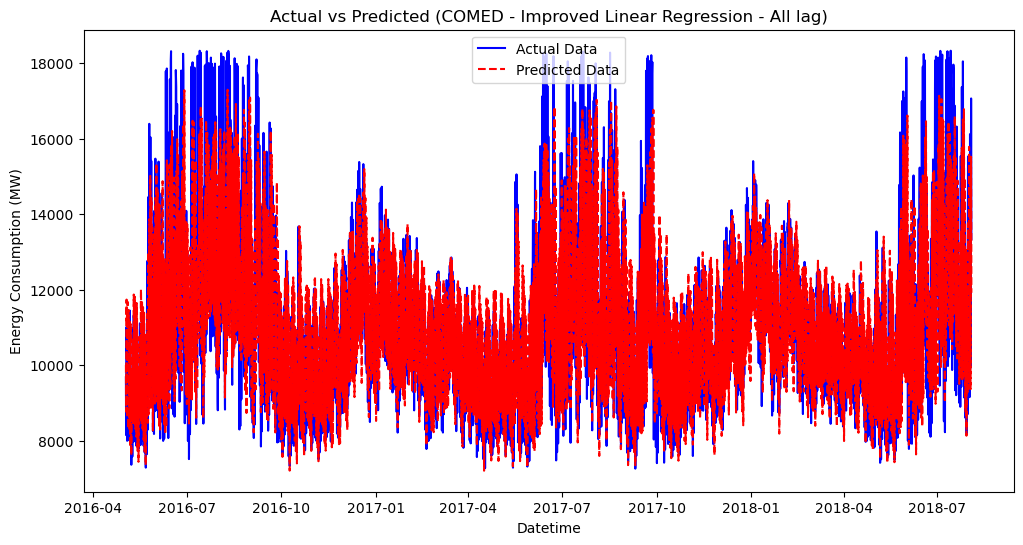

RMSE: 171.74
Normalized RMSE (Range): 0.08
Mean Absolute Percentage Error (MAPE): 6.63%


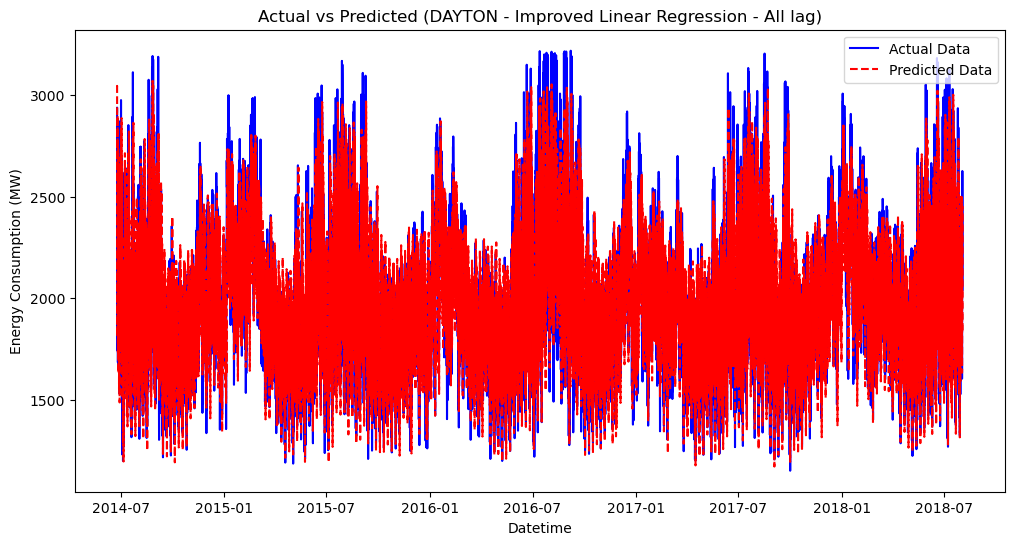

RMSE: 275.41
Normalized RMSE (Range): 0.08
Mean Absolute Percentage Error (MAPE): 6.71%


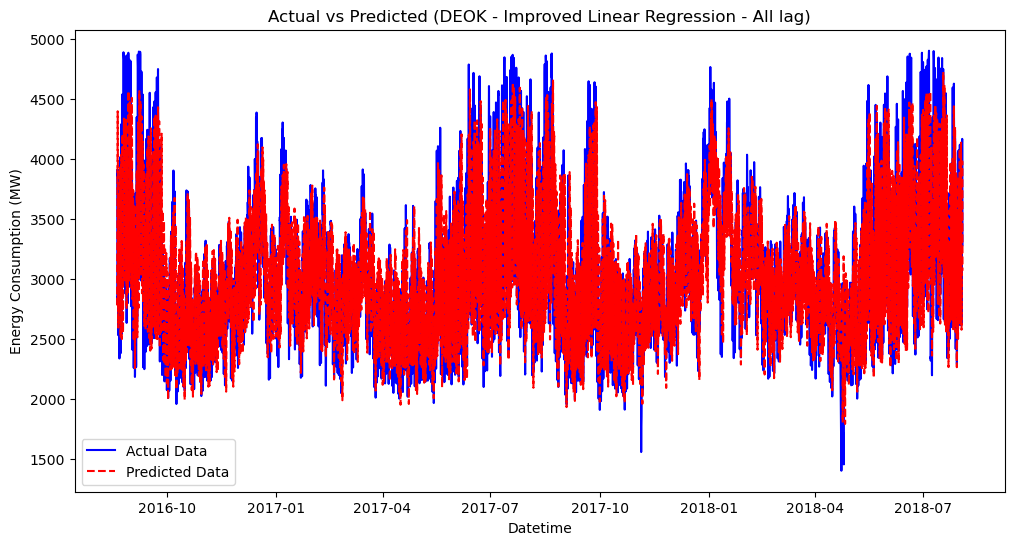

RMSE: 1153.38
Normalized RMSE (Range): 0.10
Mean Absolute Percentage Error (MAPE): 7.39%


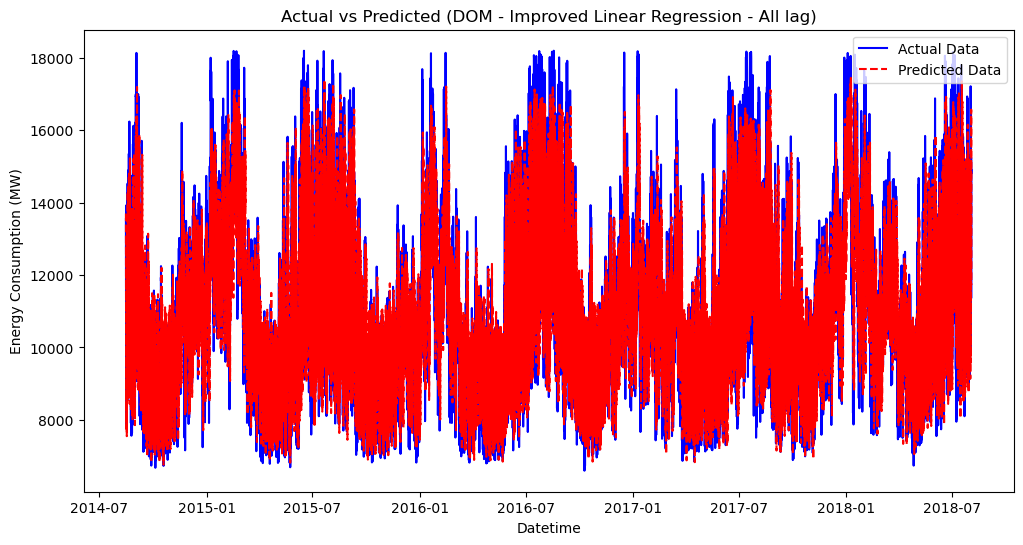

RMSE: 134.86
Normalized RMSE (Range): 0.09
Mean Absolute Percentage Error (MAPE): 6.39%


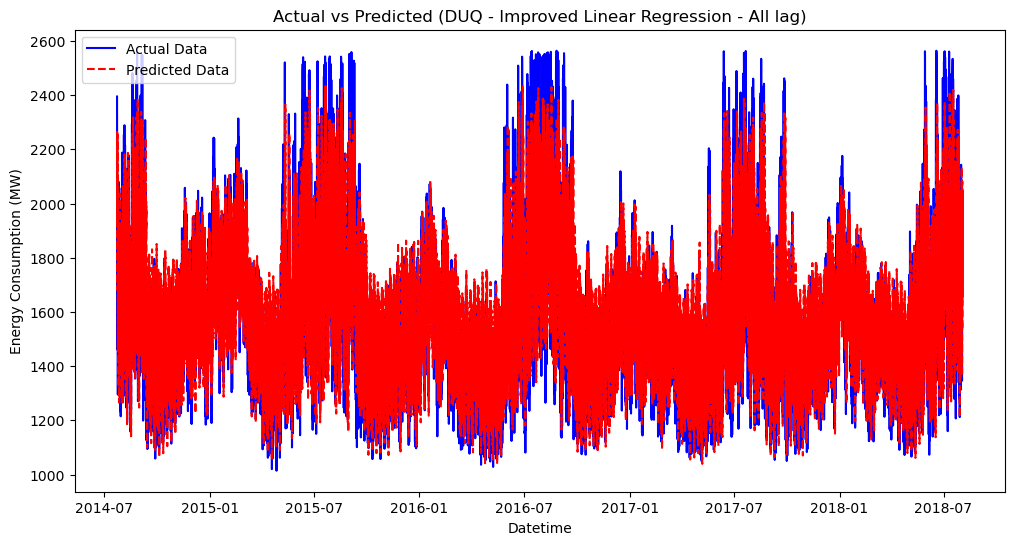

RMSE: 182.94
Normalized RMSE (Range): 0.10
Mean Absolute Percentage Error (MAPE): 9.07%


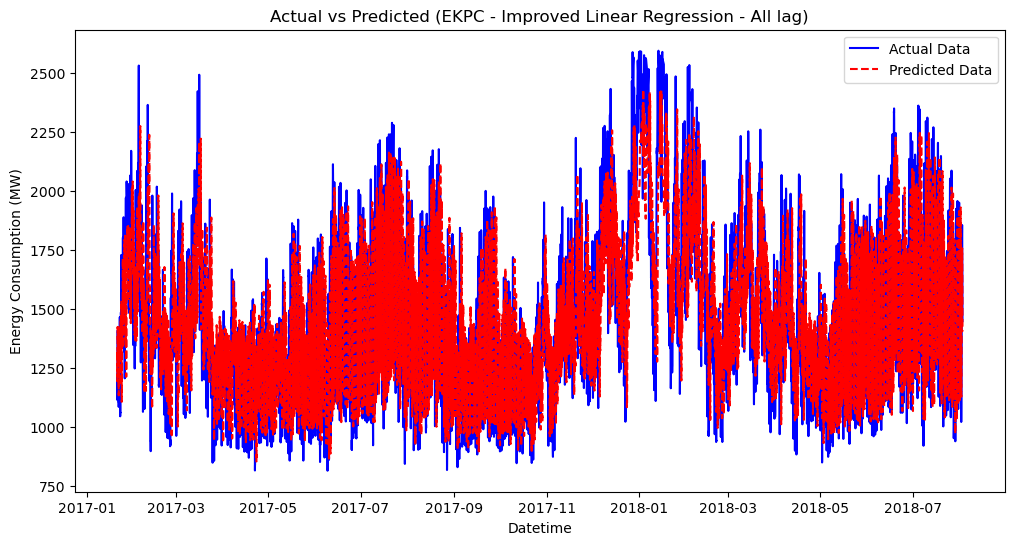

RMSE: 652.39
Normalized RMSE (Range): 0.09
Mean Absolute Percentage Error (MAPE): 6.02%


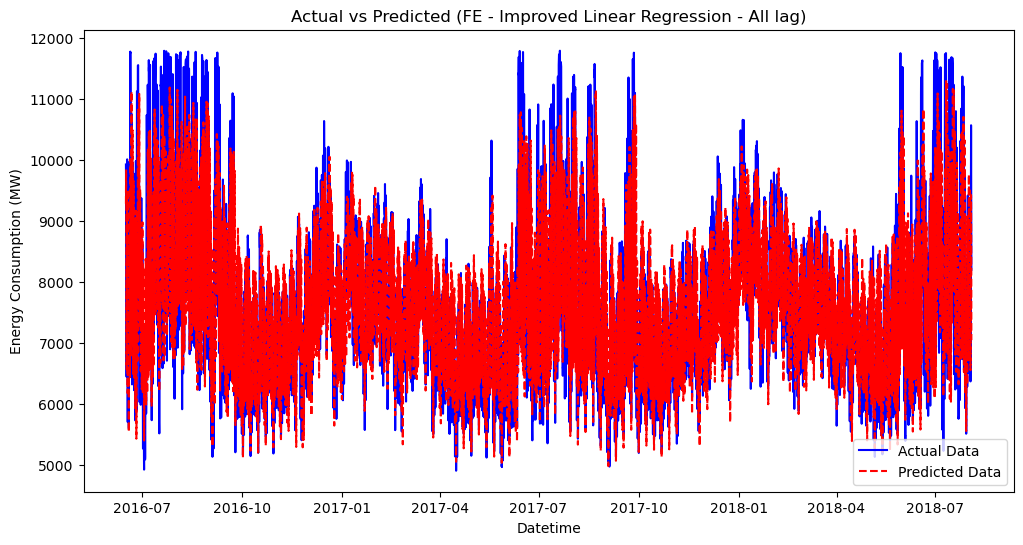

RMSE: 1014.70
Normalized RMSE (Range): 0.09
Mean Absolute Percentage Error (MAPE): 6.13%


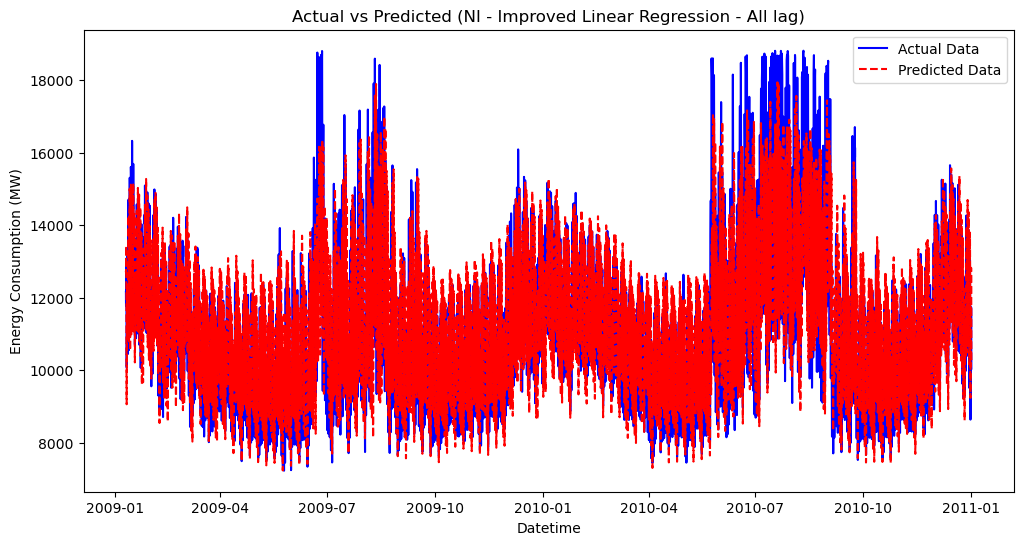

RMSE: 436.12
Normalized RMSE (Range): 0.08
Mean Absolute Percentage Error (MAPE): 5.84%


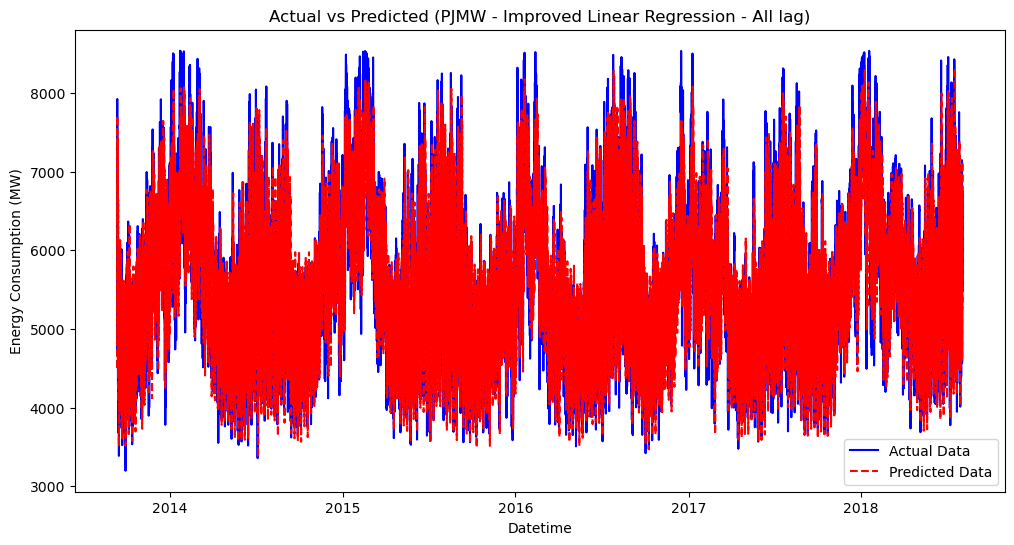

In [68]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Create cyclical and lag features
for utility, df in processed_data.items():
    target = f'{utility}_MW'
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['lag_week'] = df[target].shift(168)
    df['lag_month'] = df[target].shift(720)
    df['lag_day'] = df[target].shift(24)


    # Drop rows with NaN due to lag/rolling features
    df = df.dropna()

    # Setting features
    features = ['hour', 'day_of_week', 'month', 'lag_week','lag_day','lag_month','hour_cos','hour_sin']
    X = df[features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, shuffle=False)

    # Model training
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Prediction evalutaion and normalization
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    nrmse_range = rmse / (y_test.max() - y_test.min())
    

    print(f"RMSE: {rmse:.2f}")
    print(f"Normalized RMSE (Range): {nrmse_range:.2f}")
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted ({utility} - Improved Linear Regression - All lag)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

RMSE: 1700.4389540819752


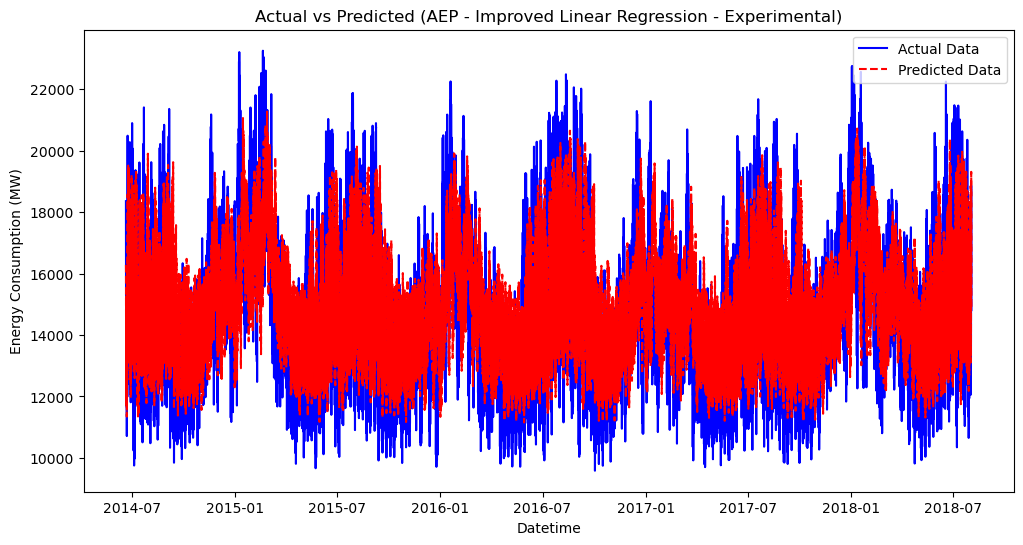

RMSE: 1700.659746766855


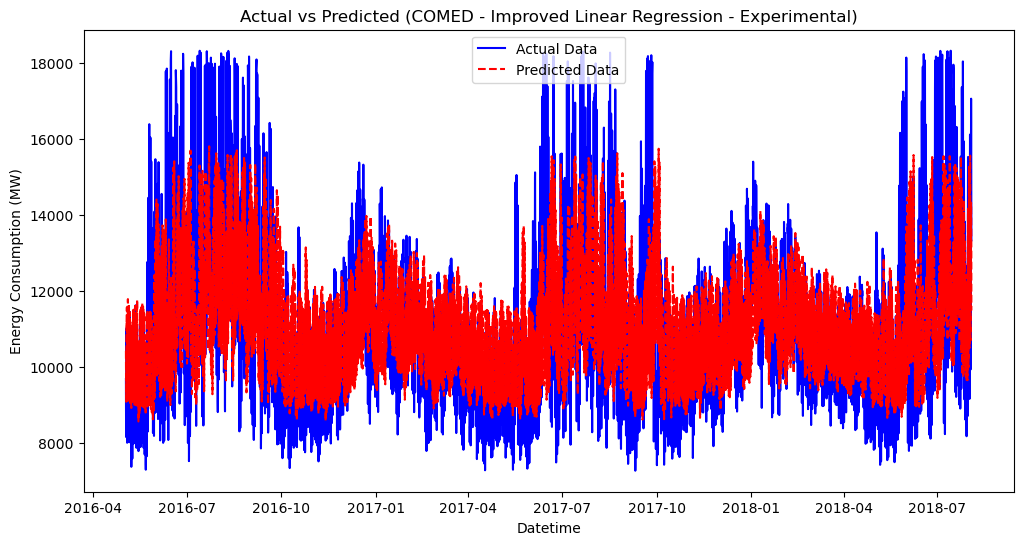

RMSE: 262.3842779917503


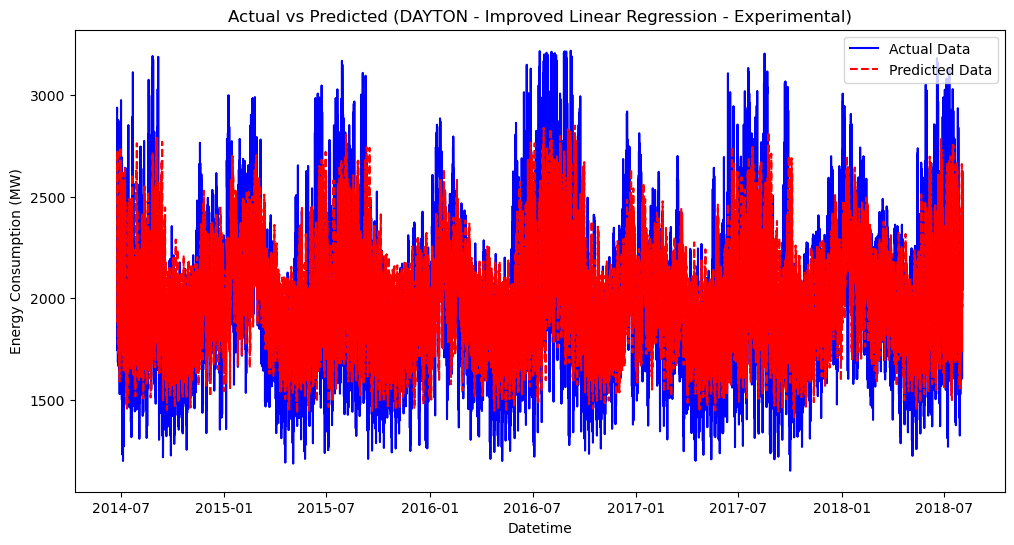

RMSE: 447.74045209762585


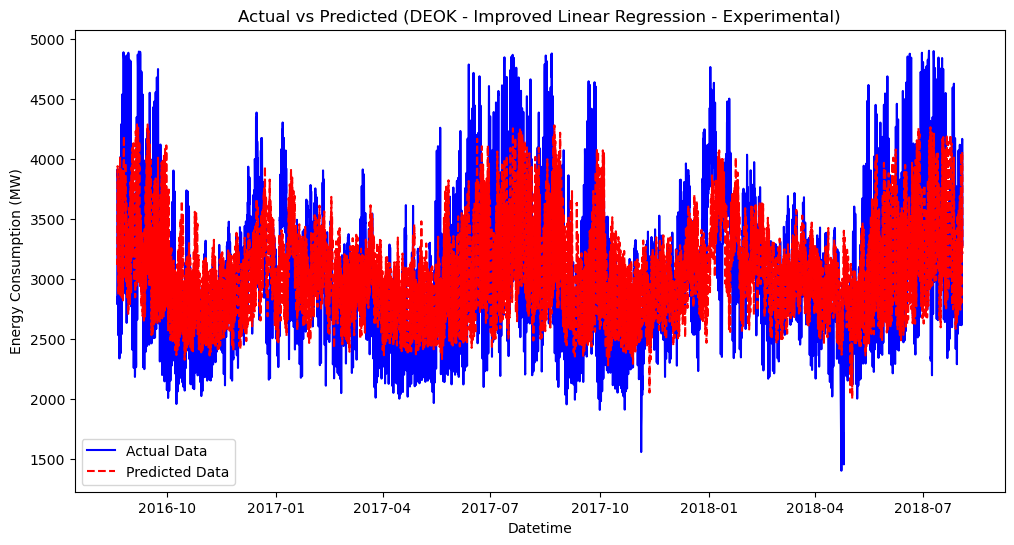

RMSE: 1829.1447195242688


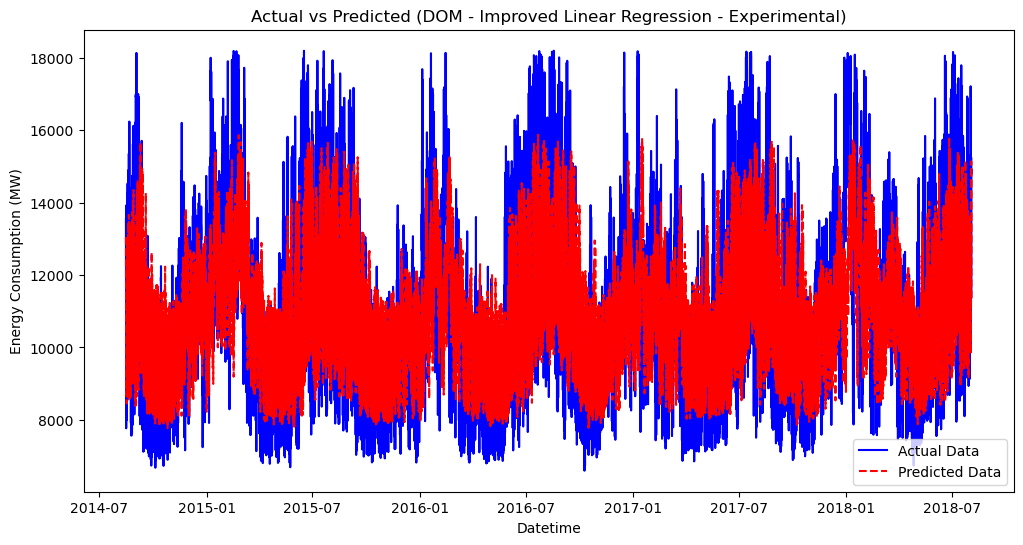

RMSE: 216.865122442792


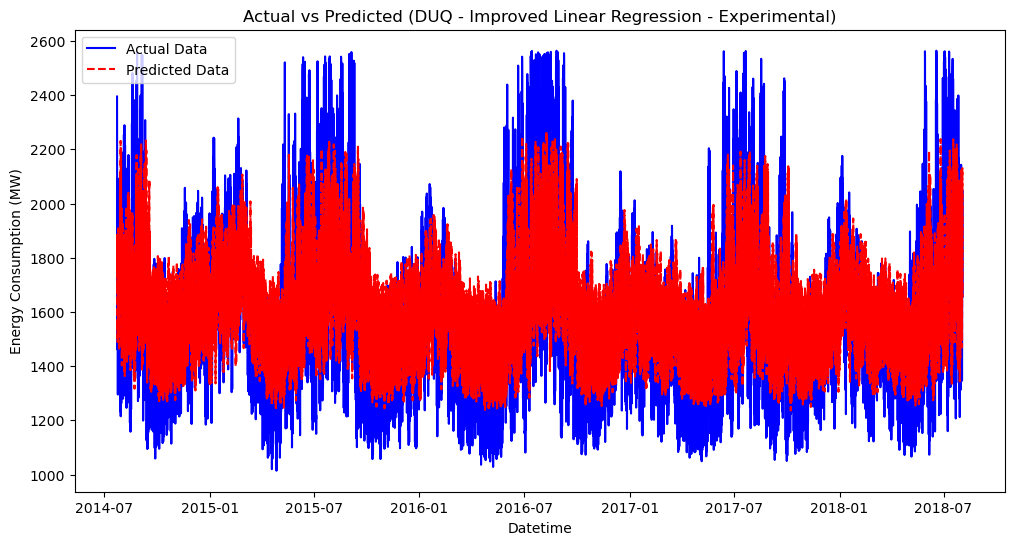

RMSE: 265.1055492432994


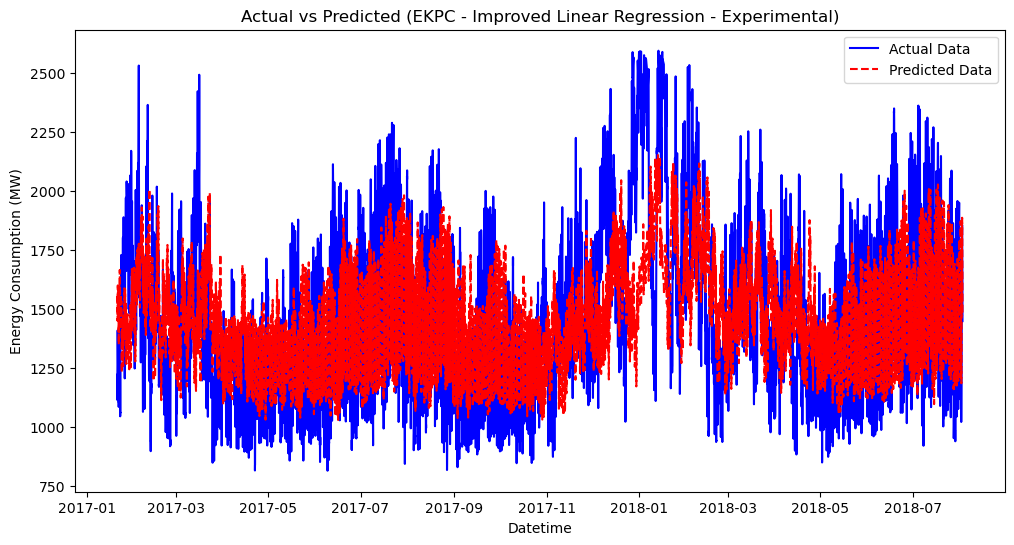

RMSE: 1027.9364841764666


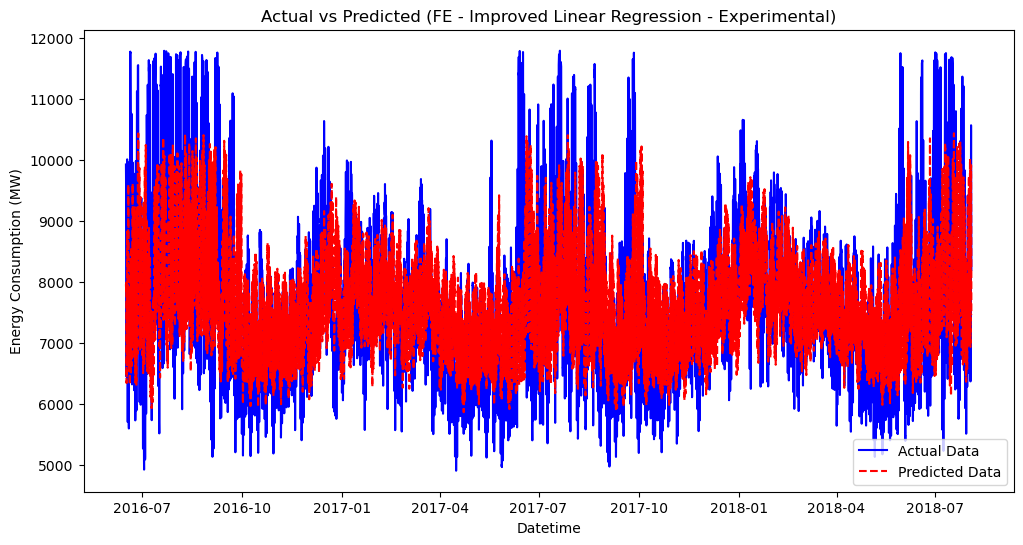

RMSE: 1444.486601510066


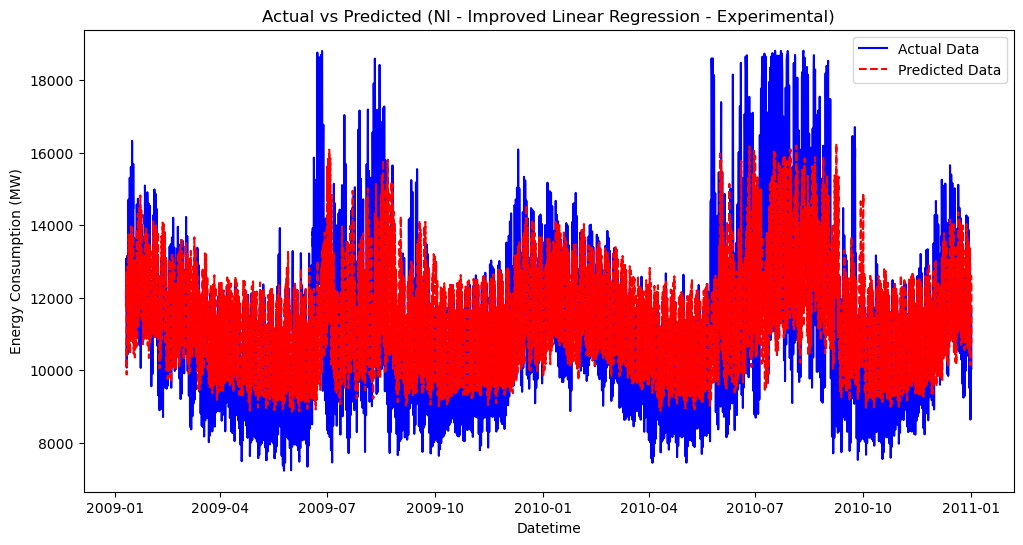

RMSE: 697.4018646493635


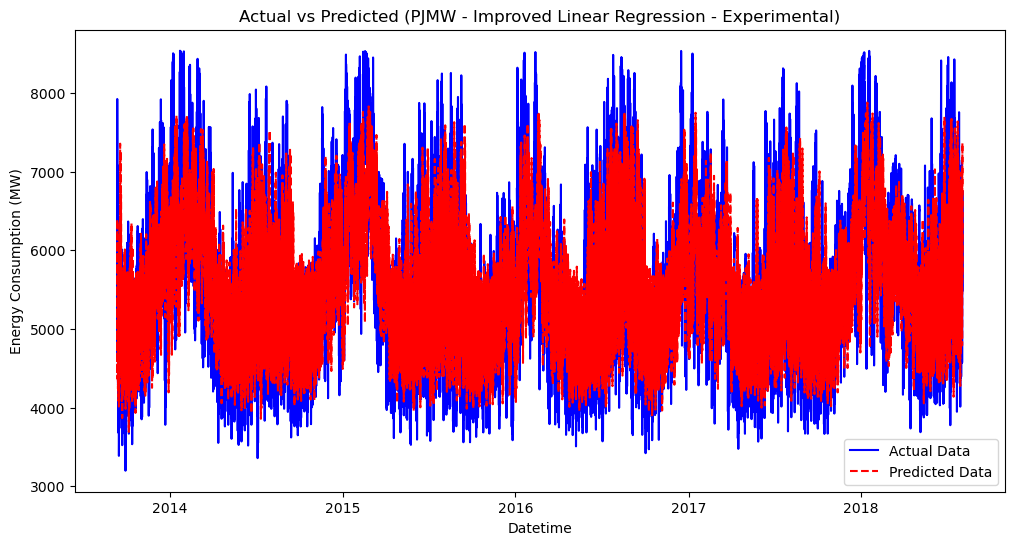

In [69]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

# Create cyclical and lag features
for utility, df in processed_data.items():
    target = f'{utility}_MW'
    df['lag_week'] = df[target].shift(168)
    df['lag_month'] = df[target].shift(720)
    df['lag_day'] = df[target].shift(24)


    # Drop rows with NaN due to lag/rolling features
    df = df.dropna()

    # Setting features
    features = ['hour', 'day_of_week', 'month', 'lag_month', 'lag_week']
    X = df[features]
    y = df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, shuffle=False)

    # Training Ridge model
    ridge = Ridge(alpha=1000000)
    ridge.fit(X_train, y_train)

    # Prediction evalutaion and normalization
    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted ({utility} - Improved Linear Regression - Experimental)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()